In [1]:
%matplotlib inline

from sqlalchemy import create_engine
import datetime
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as col
from matplotlib.dates import  DateFormatter
import seaborn as sns

import config
import  db_service
import data_preparation
import weather_service

pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

sns.set_style("whitegrid")
sns.set_context("poster")

from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_absolute_error,explained_variance_score,mean_squared_error,r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble.forest import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import linear_model
from sklearn.grid_search import GridSearchCV

from tpot import TPOTRegressor
from sklearn.model_selection import train_test_split


from sklearn.ensemble import RandomForestRegressor, VotingClassifier
from sklearn.linear_model import LassoLarsCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import FunctionTransformer, MaxAbsScaler

np.set_printoptions(precision=3,suppress=True)

/home/ramon/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/ramon/anaconda2/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
### Call this method to retrieve the data directly from DB :

# db_service.create_counts_sites_weather_holidays_day()

### Otherwise load the file :
df = pd.read_csv('data/counts_sites_weather_holidays_day.csv',parse_dates=['date'],index_col=0)

dataset_past_dict = {}
dataset_forecasts_dict ={}

### Data preparation

In [3]:
# df_forecasting = data_preparation.create_forecasting_data(datetime.date(2016,10,2),datetime.date(2016,10,10))

In [4]:
start_forecasts = datetime.date(2016,9,25)
end_forecasts = datetime.date(2016,10,9)

In [5]:
df_past = df[df.date<start_forecasts]
site = 20

In [6]:
data_past_reg = data_preparation.regularize_dataset(df_past)
data_preparation.create_predictors_and_target(data_past_reg,dataset_past_dict)

df_forecasts = data_preparation.create_forecasts_data(start_forecasts,end_forecasts)

In [7]:
df_forecasts = data_preparation.regularize_forecast(df_forecasts,dataset_past_dict)

In [8]:
data_preparation.create_predictors_and_target(df_forecasts,dataset_forecasts_dict, forecasting=True)

In [9]:
def create_X_Y_per_site(site_id):
    X = dataset_past_dict[site_id]['X'].values
    y = dataset_past_dict[site_id]['y'].values
    fields = dataset_past_dict[site_id]['X'].columns[3:].tolist()

    X_forecast = dataset_forecasts_dict[site_id]['X'].values

    y_forecast = df[(df.date>=start_forecasts)&(df.date<=end_forecasts)&(df.idbldsite==site_id)].compensatedin.values
    return X,y,fields,X_forecast,y_forecast

### Pipeline

In [10]:
def cv_optimize(clf, parameters, X, y, n_jobs=1, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
    gs.fit(X, y)
    print "BEST", gs.best_params_, gs.best_score_, gs.grid_scores_
    best = gs.best_estimator_
    return best

In [11]:
def do_classify(clf, parameters, X,y, mask=None, score_func=None, n_folds=5, n_jobs=1):
    # remove index and idbldsite
    X,y = X[:,3:],y[:,2:].ravel()
    Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,test_size=0.3)
    clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_jobs=n_jobs, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    
    print "############# based on standard predict ################"
    print "Accuracy on training data: %0.2f" % (training_accuracy)
    print "Accuracy on test data:     %0.2f" % (test_accuracy)
    print "########################################################"
   
#     try:
#         print pd.DataFrame(zip(clf.feature_importances_,fields))
#     except :
#         print "no feature_importance"
    print "########################################################"
    return clf, Xtrain, ytrain, Xtest, ytest

In [12]:
def compute_forecasting_quality(clf,X,y_true):
    quality_scores = []
    print clf.score(X,y_true)
    y_pred = clf.predict(X)
    quality_scores.append(("mean_absolute_error :" ,mean_absolute_error(y_true,y_pred)))
    quality_scores.append(("Var(MSE) :" ,mean_squared_error(y_true,y_pred)))
    quality_scores.append(("Var(y) : " ,(np.std(y_pred))**2))
    quality_scores.append(("1- mse/y_std : " ,1-(mean_squared_error(y_true,y_pred))/(np.std(y_pred))**2))
    quality_scores.append(("explained_variance_score: " , explained_variance_score(y_true,y_pred)))
    quality_scores.append(("r2_score : " ,r2_score(y_true,y_pred)))
       
    df =  pd.DataFrame(quality_scores,columns=['indicator','value'])
    df = df.set_index('indicator')
    return df

#### RandomForestRegressor

In [39]:
clf_RDM = {'params' : {'n_estimators':[300],'bootstrap':[True], 'criterion':['mse']},'clf':RandomForestRegressor()}


#### GradientBoostingRegressor

In [14]:

# clf_gbr = GradientBoostingRegressor()
# params = {'loss' : ['ls', 'lad', 'huber', 'quantile']}

# clf_gbr, Xtrain, ytrain, Xtest, ytest = do_classify(clf_gbr,params,X,y)
# print clf_gbr.score(Xtest,ytest)

#### BayesianRidge


In [15]:
# clf_br = linear_model.BayesianRidge()
# params = {'alpha_1':[1e-10,1e-11,1e-12,1e-09], 'alpha_2':[1e-09,1e-08],
#        'lambda_1':[1e-08,1e-06,1e-05,1e-04], 'lambda_2':[1e-12,1e-13], 
#           'n_iter':[300,600,1000],
#         'tol':[0.001,0.00001,0.0001,0.01], 'verbose':[False],'compute_score':[False]}

# clf_br, Xtrain, ytrain, Xtest, ytest = do_classify(clf_br,params,X,y)


#### Linear regression

In [16]:
# clf_lr = LinearRegression()
# clf_lr.fit(Xtrain,ytrain)
# clf_lr.score(Xtest,ytest)

#### Lasso

In [43]:
clf_LASSO = {'clf' :linear_model.Lasso(),'params' : {'alpha': [0.000001,0.0001,0.001,0.01,0.1,1,10,20,30,40,100,500]}}


#### SGD Regressor

In [18]:
# clf_sgd = linear_model.SGDRegressor()
# params = {'alpha':[0.000001,0.0001,0.001,0.01,0.1,1,10,20,30,40,100,500]}
# clf_sgd, Xtrain, ytrain, Xtest, ytest = do_classify(clf_sgd,params,X,y)
# compute_forecasting_quality(clf_sgd,X_forecast[:,3:],y_forecast)

#### TPOT Predictor

In [66]:
clf_TPOT = make_pipeline(
    MaxAbsScaler(),
    make_union(VotingClassifier([("est", LassoLarsCV(normalize=False))]), FunctionTransformer(lambda X: X)),
    RandomForestRegressor(n_estimators=800))

In [81]:
def plot_forecasts(axs,i,site_id,site_name,clf_list,X_forecast,y_forecast):
    
    axs[i].bar(df_forecasts[df_forecasts.idbldsite==site].date.values,y_forecast,alpha=0.7,color='grey',align='center')
    axs[i].set_title(site_name,fontsize=14)
#     axs[i].set_axis_bgcolor(BACKGROUND_COLOR)

    for clf in clf_list:
        axs[i].plot(df_forecasts[df_forecasts.idbldsite==site].date.values,(clf.predict(X_forecast[:,3:])))
    
    for label in axs[i].get_xticklabels():
        label.set_fontname('Arial')
        label.set_fontsize(8)
        label.set_rotation(90)
        
    for label in axs[i].get_yticklabels():
        label.set_fontname('Arial')
        label.set_fontsize(8)
        
   
    axs[0].legend(['Randomforest','Lasso','Tpot'],loc=0)

In [82]:
def draw_forecast():
    site_dict = db_service.get_sites_dict()
    sites_ids = site_dict.keys()
    plots_rows_nbr = (len(sites_ids[:2]))/2+2
    print plots_rows_nbr
    fig, axs = plt.subplots(plots_rows_nbr,2, figsize=(12, 24), facecolor='w', edgecolor='k', sharex=False, sharey=True)
    fig.subplots_adjust(hspace = .5, wspace=.2)
    fig.suptitle("Total In forecasts")
    axs = axs.ravel()
    
    for i,site_id in enumerate(sites_ids[:2]):
        print "site_id :" + str(site_id)
        X,y,fields,X_forecast,y_forecast = create_X_Y_per_site(site_id)
        
        clf = clf_RDM['clf']
        params = clf_RDM['params']
        clf_rdm, Xtrain, ytrain, Xtest, ytest = do_classify(clf,params,X,y)
        
        clf = clf_LASSO['clf']
        params = clf_LASSO['params']
        clf_lasso, Xtrain, ytrain, Xtest, ytest = do_classify(clf,params,X,y)
        
        clf_tpot = make_pipeline(MaxAbsScaler(),
                                          make_union(VotingClassifier([("est", LassoLarsCV(normalize=False))]), FunctionTransformer(lambda X: X)),
                                          RandomForestRegressor(n_estimators=800))
        clf_tpot.fit(X[:,3:],y[:,2:].ravel())
        
        compute_forecasting_quality(clf_rdm,X_forecast[:,3:],y_forecast)
        plot_forecasts(axs,i,site_id,site_dict[site_id][0],[clf_rdm,clf_lasso,clf_tpot],X_forecast,y_forecast)
        

3
site_id :1
BEST {'n_estimators': 300, 'bootstrap': True, 'criterion': 'mse'} 0.686671761977 [mean: 0.68667, std: 0.13967, params: {'n_estimators': 300, 'bootstrap': True, 'criterion': 'mse'}]
############# based on standard predict ################
Accuracy on training data: 0.96
Accuracy on test data:     0.72
########################################################
########################################################
BEST {'alpha': 10} 0.739590935697 [mean: 0.73730, std: 0.06667, params: {'alpha': 1e-06}, mean: 0.73730, std: 0.06667, params: {'alpha': 0.0001}, mean: 0.73730, std: 0.06667, params: {'alpha': 0.001}, mean: 0.73731, std: 0.06667, params: {'alpha': 0.01}, mean: 0.73737, std: 0.06665, params: {'alpha': 0.1}, mean: 0.73783, std: 0.06639, params: {'alpha': 1}, mean: 0.73959, std: 0.06436, params: {'alpha': 10}, mean: 0.73744, std: 0.06371, params: {'alpha': 20}, mean: 0.73097, std: 0.06434, params: {'alpha': 30}, mean: 0.72135, std: 0.06525, params: {'alpha': 40}, mean

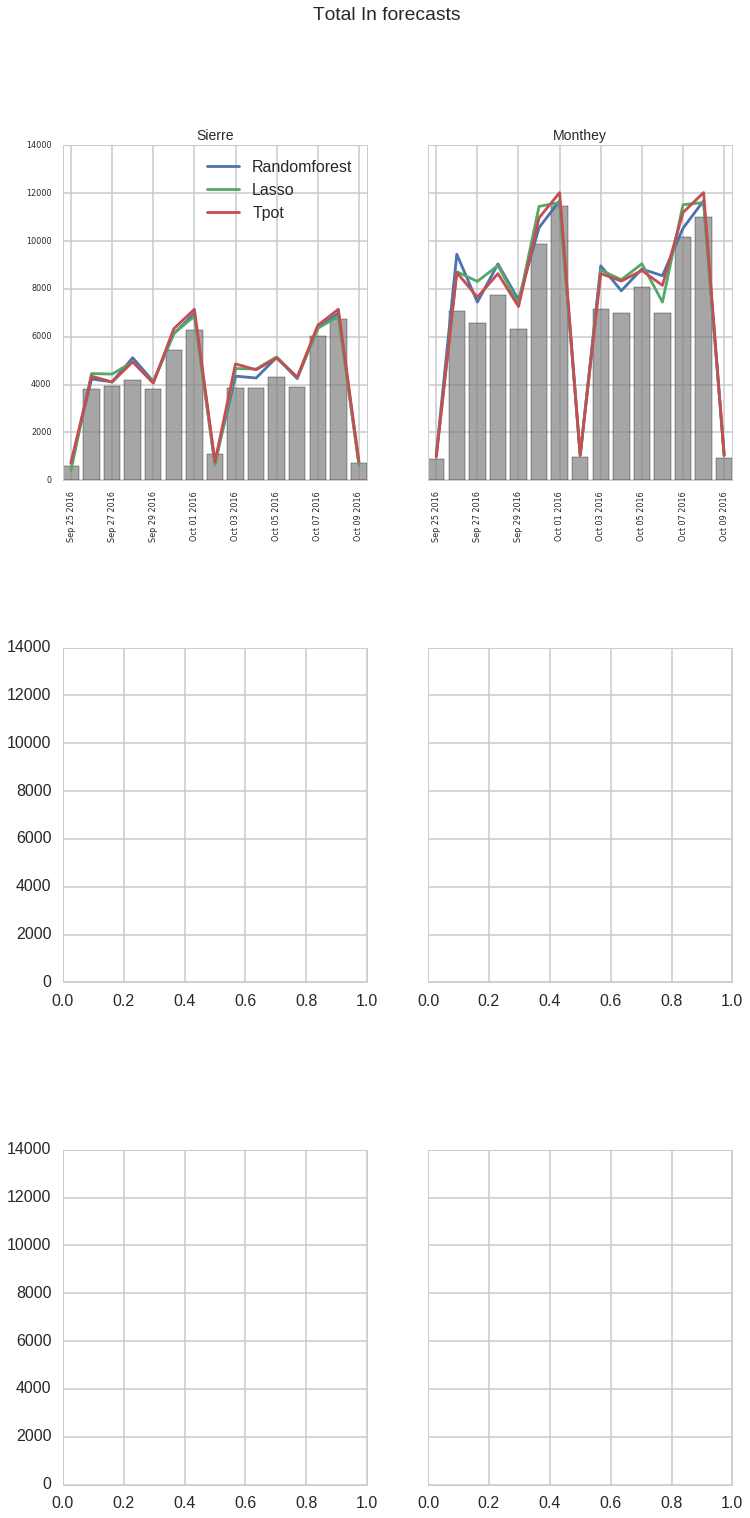

In [83]:
draw_forecast()